In [1]:
import pandas as pd

In [2]:
# Here, I loaded the datasets
df1 = pd.read_excel("/content/Mizo_Training_Software_project.xlsx")

In [3]:
df1.head()

,Text,Sentiment
0,"He video hi en suh u, hun khawhralna a ni.",NEGATIVE
1,I video te hi ka ngaina lo hle.,NEGATIVE
2,i video ah hian information rintlak loh a tam ...,NEGATIVE
3,Ngati nge i video hi a chhiat emem mai le?,NEGATIVE
4,I video te hi a tha tawk lo niin ka hria,NEGATIVE


In [4]:
#df2 = pd.read_excel("/content/English_dataset.xlsx")

In [5]:
#df3 =  pd.read_excel("/content/Mizo_Training_Software_project.xlsx")

In [6]:
#df4 = pd.read_excel("/content/Telugu_soft_ware_project.xlsx")

In [7]:
#df5 = pd.read_excel("/content/german_sentiment.xlsx")

In [8]:
# Concatenate the datasets
#df = pd.concat([df1,df2,df3,df4,df5])

In [9]:
df = df1

In [10]:
# Here, I see information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       6000 non-null   object
 1   Sentiment  6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [11]:
# Here, I converted the labels to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Sentiment'] = le.fit_transform(df.Sentiment.values)

In [12]:
# Here, I shuffled the dataframe
from sklearn.utils import shuffle
df = shuffle(df)

In [13]:
df

,Text,Sentiment
5771,"He hla hi painting ni ta se, mittens vuah mi p...",0
2355,ZPM aiawh Pu Tbca pawhin a sawi tha hle,1
5076,He indie-electronic masterpiece hi sonic adven...,1
1810,Film-a [insert trendy filmmaking technique] hm...,0
4368,Protocol chiang tak awm lovin chhiatrupna thle...,0
...,...,...
5627,He album ngaihthlak hi elevator-a hold music t...,0
3845,"Electoral college system hian mi pakhat, vote ...",0
2085,"A fing hle a, a fel em em bawk a, ui pawh an t...",1
1783,He hla ngaihthlak hi mit khap chunga maze-a ka...,0


In [14]:
# Here, I counted the number of positive and negative labels
positive_labels = (df['Sentiment'] == 1).sum()
negative_labels = (df['Sentiment'] == 0).sum()
print(f"Number of positive labels: {positive_labels}")
print(f"Number of negative labels: {negative_labels}")

Number of positive labels: 3000
Number of negative labels: 3000


In [15]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels_str, val_labels_str = train_test_split(list(df['Text']), list(df['Sentiment']), test_size=.2)

In [16]:
# Install required packages
!pip install sentencepiece
!pip install transformers
!pip install transformers accelerate
!pip install torch==1.11.00.676617

ERROR: Could not find a version that satisfies the requirement torch==1.11.00.676617 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1)
ERROR: No matching distribution found for torch==1.11.00.676617


In [17]:
# Load tokenizer and model
from transformers import BertTokenizer, BertModel
import torch

In [18]:
# Change the tokenizer and model to mBERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# Ensure all elements are strings
train_texts = [str(text) for text in train_texts]
val_texts = [str(text) for text in val_texts]

In [20]:
# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [21]:
# Define custom dataset class
class ChungliAo_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
# Encode labels
train_labels = le.fit_transform(train_labels_str)
val_labels = le.transform(val_labels_str)

# Create dataset objects
train_dataset = ChungliAo_Dataset(train_encodings, train_labels)
val_dataset = ChungliAo_Dataset(val_encodings, val_labels)

In [23]:
# Additional classification layer on top of the model
import torch.nn as nn

class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomClassifier, self).__init__()
        self.base_model = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the representation of [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

In [25]:
# Instantiate the custom model
model_name = 'bert-base-multilingual-cased'
num_labels = 2  # Number of classes for classification
custom_model = CustomClassifier(model_name, num_labels)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [26]:
# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {'Accuracy': acc, 'F1': f1, 'Precision': precision, 'Recall': recall}

In [27]:
# Define training arguments
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    do_eval=True,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=10
)

# Initialize the Trainer
trainer = Trainer(
    model=custom_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # compute metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

# Train the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.705200,0.720605,0.394167,0.394167,0.394167,0.394167
20,0.713000,0.698396,0.460000,0.460000,0.460000,0.460000
30,0.694500,0.658708,0.719167,0.719167,0.719167,0.719167
40,0.655000,0.600514,0.806667,0.806667,0.806667,0.806667
50,0.603900,0.494384,0.827500,0.827500,0.827500,0.827500
60,0.480800,0.383000,0.869167,0.869167,0.869167,0.869167
70,0.418100,0.339061,0.855833,0.855833,0.855833,0.855833
80,0.313700,0.299536,0.892500,0.892500,0.892500,0.892500
90,0.315900,0.417239,0.877500,0.877500,0.877500,0.877500
100,0.466000,0.544224,0.775833,0.775833,0.775833,0.775833


{'eval_loss': 0.15366429090499878, 'eval_Accuracy': 0.9508333333333333, 'eval_F1': 0.9508333333333333, 'eval_Precision': 0.9508333333333333, 'eval_Recall': 0.9508333333333333, 'eval_runtime': 13.3976, 'eval_samples_per_second': 89.568, 'eval_steps_per_second': 5.598, 'epoch': 2.3}


In [28]:
test_df = pd.read_excel("/content/Chungli_Ao_test.xlsx")

In [29]:
len(test_df)

2000

In [30]:
test_df.head()

,Text,Sentiment
0,tajungtiba nung anir. ATMA staff dang o tajung...,POSITIVE
1,Iba osang atema onok dang agitsüpur ajak iba t...,POSITIVE
2,ni iba tasen ba ya meimer,POSITIVE
3,Aba tasayaba ya ajak dang tajungtiba,POSITIVE
4,Tajitettsütem Symptoms: (tang tashi nung angaz...,POSITIVE


In [31]:
test_texts = list(test_df['Text'])

In [32]:
test_df.tail()

,Text,Sentiment
1995,parnok kong aliar mejangja; süadoker asü tepuo...,NEGATIVE
1996,Magadh Range nunga DIG inyakogo.Taoba mapang C...,NEGATIVE
1997,(FLWs) aser arishi küm 45 ser temapur nem vacc...,NEGATIVE
1998,"Director, Rev Atha Neikha ajanga sayatsü. Iba ...",NEGATIVE
1999,melenshija lir.Democracy busema longkak aitba ...,NEGATIVE


In [33]:
test_df['Sentiment'] = le.fit_transform(test_df.Sentiment.values)

In [34]:
test_labels = test_df['Sentiment']

In [35]:
len(test_labels)

2000

In [36]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = ChungliAo_Dataset(test_encodings, test_labels)

In [37]:
test_metrics = trainer.evaluate(test_dataset)

In [38]:
print(test_metrics)

{'eval_loss': 1.788676381111145, 'eval_Accuracy': 0.518, 'eval_F1': 0.518, 'eval_Precision': 0.518, 'eval_Recall': 0.518, 'eval_runtime': 57.9105, 'eval_samples_per_second': 34.536, 'eval_steps_per_second': 2.159, 'epoch': 2.3}


File saved as misclassified_claims_Telugu_test_set.xlsx
Sentiment
0    932
1     32
dtype: int64


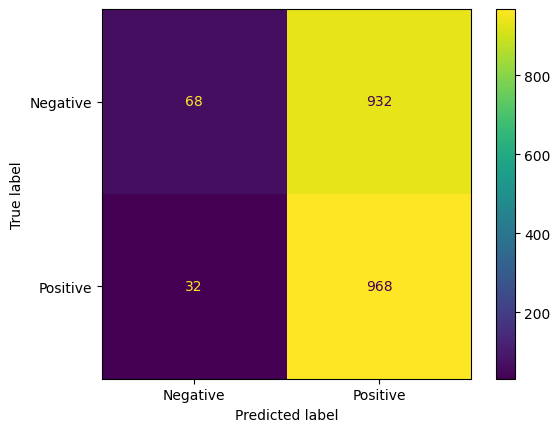

In [39]:
#Here I made the predictions on the test dataset using the trained model
test_predictions = trainer.predict(test_dataset)

# Here I converted the predictions into label indices by taking the argmax
pred_labels = test_predictions.predictions.argmax(-1)

# Here I assigned the predicted labels to a new column in the test dataframe
test_df['Predicted_Label'] = pred_labels

# Here I created a new column in the test dataframe that checks if the predicted label matches the true label
test_df['Correct'] = test_df['Sentiment'] == test_df['Predicted_Label']

# Here I filtered the dataframe to include only the rows where the prediction was incorrect
misclassified = test_df[test_df['Correct'] == False]

# Here I displayed the columns 'Claim', 'Label', and 'Predicted_Label' from the misclassified examples
misclassified[['Text', 'Sentiment', 'Predicted_Label']]

# Save the misclassified claims into a dataframe
misclassified_df = misclassified[['Text', 'Sentiment', 'Predicted_Label']]

file_path = 'misclassified_claims_Telugu_test_set.xlsx'
misclassified_df.to_excel(file_path, index=False)

print(f"File saved as {file_path}")

# Here I created a confusion matrix of the test set based on the results of the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_df['Sentiment'], test_df['Predicted_Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

# Here I wanted to see which labels are misclassified
category_errors = misclassified.groupby('Sentiment').size()
print(category_errors)

#Pushing_the_model_to_hugging_face

In [40]:
from huggingface_hub import login
login()

In [41]:
from huggingface_hub import create_repo

# Create a new repository with the desired name
repo_name = "Zero_shot_Soft_ware_project_Mbert"  # Desired repository name
create_repo(repo_name)

RepoUrl('https://huggingface.co/Blue7Bird/Zero_shot_Soft_ware_project_Mbert', endpoint='https://huggingface.co', repo_type='model', repo_id='Blue7Bird/Zero_shot_Soft_ware_project_Mbert')

In [43]:
from transformers import BertForSequenceClassification

# Load the model
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)  #  binary classification
model.resize_token_embeddings(len(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(119547, 768, padding_idx=0)

In [44]:
model.save_pretrained("/content/results")
tokenizer.save_pretrained("/content/results")

('/content/results/tokenizer_config.json',
 '/content/results/special_tokens_map.json',
 '/content/results/vocab.txt',
 '/content/results/added_tokens.json')

In [46]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("/content/results")
model = AutoModelForSequenceClassification.from_pretrained("/content/results")

In [47]:
model.push_to_hub("Blue7Bird/Zero_shot_Soft_ware_project_Mbert")
tokenizer.push_to_hub("Blue7Bird/Zero_shot_Soft_ware_project_Mbert")

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Blue7Bird/Zero_shot_Soft_ware_project_Mbert/commit/57ecdbda385d5f6d92cf64e3462b0d1e452566bb', commit_message='Upload tokenizer', commit_description='', oid='57ecdbda385d5f6d92cf64e3462b0d1e452566bb', pr_url=None, pr_revision=None, pr_num=None)